In [1]:
import numpy as np
import h5py
import os, sys
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
import yaml
import argparse
import xml.etree.ElementTree as ET

sys.path.append('../')
import utils
import settings
plt.style.use('../spectrum.mplstyle')

In [2]:
log_filter = np.array([x.endswith("log") for x in os.listdir()])
log_files = np.array(os.listdir())[log_filter]
print(log_files)

['isodoublet_nonstrange_multi.isodoublet_S0_G1u_P0_single_pivot_n8_m8_d16_c50.log'
 'isodoublet_nonstrange_multi.isodoublet_S0_G1_P1_single_pivot_n8_m8_d16_c50.log'
 'isodoublet_nonstrange_multi.isodoublet_S0_G1_P4_single_pivot_n8_m8_d16_c50.log'
 'isodoublet_nonstrange_multi.isodoublet_S0_G_P2_single_pivot_n8_m8_d16_c50.log'
 'isodoublet_nonstrange_multi.isodoublet_S0_G_P3_single_pivot_n8_m8_d16_c50.log']


isotriplet S=0 P=(0,0,0) A1um P[SS0] 0
isotriplet S=0 PSQ=1 A2m P[SS1] 0
isodoublet S=0 P=(0,0,0) G1g N[SS0] 0
isodoublet S=0 PSQ=1 G1 N[SS0] 0
isodoublet S=0 PSQ=2 G N[SS0] 0
isodoublet S=0 PSQ=3 G N[SS0] 0
isodoublet S=0 PSQ=4 G1 N[SS0] 0
isodoublet S=0 P=(0,0,0) G1u ROT 0
isodoublet S=0 P=(0,0,0) G1u ROT 1
isodoublet S=0 PSQ=1 G1 ROT 0
isodoublet S=0 PSQ=1 G1 ROT 1
isodoublet S=0 PSQ=1 G1 ROT 2
isodoublet S=0 PSQ=4 G1 ROT 0
isodoublet S=0 PSQ=4 G1 ROT 1
isodoublet S=0 PSQ=4 G1 ROT 2
isodoublet S=0 PSQ=2 G ROT 0
isodoublet S=0 PSQ=2 G ROT 1
isodoublet S=0 PSQ=2 G ROT 2
isodoublet S=0 PSQ=2 G ROT 3
isodoublet S=0 PSQ=3 G ROT 0
isodoublet S=0 PSQ=3 G ROT 1
isodoublet S=0 PSQ=3 G ROT 2
isodoublet S=0 PSQ=3 G ROT 3


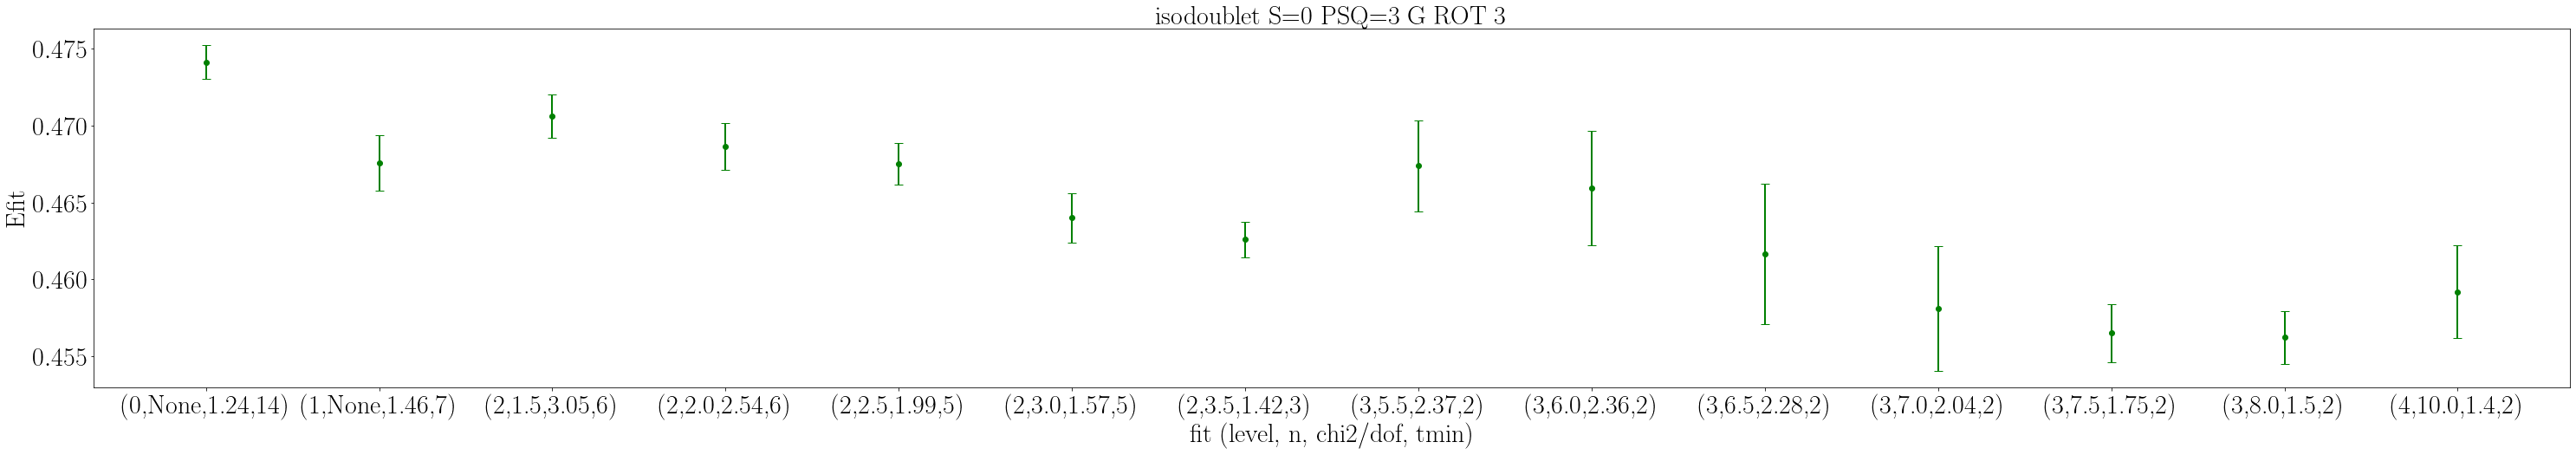

In [3]:
f = plt.figure(facecolor="white")
f.set_figwidth(14)
f.set_figheight(8)
completed_ops = []
for log_file in log_files:
    data = ET.parse(log_file)
    root = data.getroot()
    for item in root.findall('./Task/DoFit'):
        if item.find("./Type").text =="TemporalCorrelator":
            plt.clf()
            corr = item.find('./TemporalCorrelatorFit/GIOperatorString').text
            if corr not in completed_ops:
                print(corr)
                level = []
                n = []
                fit_values = []
                fit_errs = []
                chi2dof = []
                tmins = []
                for fit_level in item.findall('./IntermediateFitResults'):
                    level.append(int(fit_level.find('./FitLevel').text))
                    if fit_level.findall(f'./N{level[-1]}'):
                        n.append( round(float(fit_level.find(f'./N{level[-1]}').text),1) )
                    else: 
                        n.append(None)
                    fit_values.append( float(fit_level.find('./EnergyFitValue').text) )
                    fit_errs.append( float(fit_level.find('./EnergyErrValue').text) )
                    chi2dof.append( round(float(fit_level.find('./ChiSqDof').text),2) )
                    tmins.append( int(fit_level.find('./Tmin').text) )

                    if fit_values[-1]< 0.0001:
                        level.pop()
                        n.pop()
                        fit_values.pop()
                        fit_errs.pop()
                        chi2dof.pop()
                        tmins.pop()

                x_values = [f"({this_level},{this_n},{this_chi},{thic_tmin})" for this_level, this_n, this_chi, thic_tmin in zip(level,n,chi2dof,tmins)]
                f.set_figwidth(3*len(x_values))
                plt.errorbar( x_values, fit_values,fit_errs,marker=settings.markers[0],color=settings.colors[0],lw=0.0, elinewidth=2.0, capsize=5.0)
                plt.xlabel( 'fit (level, n, chi2/dof, tmin)')
                plt.ylabel('Efit')
                plt.title(corr)
                plt.tight_layout()
                plt.savefig(corr.replace(" ","_")+".png")
                completed_ops.append(corr)
